In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-06-04 06:07:27--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.9.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.9.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  70.4MB/s    in 22s     

2020-06-04 06:07:49 (71.9 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



2020-06-04 06:07:55,459 : INFO : loading projection weights from /root/input/GoogleNews-vectors-negative300.bin.gz


 1    6252
-1    4210
 0    1583
Name: sent_score, dtype: int64
['itali', 'prove', 'pc', 'sometim', 'danger', 'note', 'covid', 'case', 'soar', 'sadli', 'idiot', 'hug', 'chines', 'day', 'meanwhil', 'chines', 'gov', 'use', 'propaganda', 'corona', 'chineseviru']


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-04 06:07:56,983 : INFO : loaded (50000, 300) matrix from /root/input/GoogleNews-vectors-negative300.bin.gz


(12045, 30)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           15000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 100)           160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 30, 64)            6464      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 8)             2568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 8)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 8)            

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8672 samples, validate on 2168 samples
Epoch 1/5
8672/8672 [==============================] - 59s 7ms/step - loss: 12.7412 - accuracy: 0.5181 - val_loss: 12.5342 - val_accuracy: 0.5244
Epoch 2/5
8672/8672 [==============================] - 59s 7ms/step - loss: 12.7412 - accuracy: 0.5181 - val_loss: 12.5342 - val_accuracy: 0.5244
Epoch 3/5
8672/8672 [==============================] - 59s 7ms/step - loss: 12.7412 - accuracy: 0.5181 - val_loss: 12.5342 - val_accuracy: 0.5244
Epoch 4/5
8672/8672 [==============================] - 58s 7ms/step - loss: 12.7412 - accuracy: 0.5181 - val_loss: 12.5342 - val_accuracy: 0.5244
Epoch 5/5
8672/8672 [==============================] - 58s 7ms/step - loss: 12.7412 - accuracy: 0.5181 - val_loss: 12.5342 - val_accuracy: 0.5244


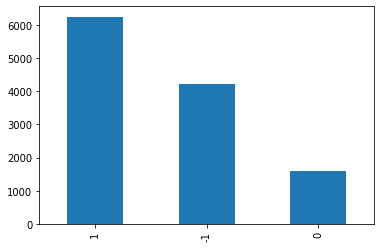

In [ ]:
from keras.utils.vis_utils import plot_model
import gensim.models.keyedvectors as word2vec
from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Conv1D, Dense, Flatten, MaxPooling1D, Dropout, SpatialDropout1D, Conv2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report

import logging

logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)


np.random.seed(24)
tweetsData = pd.read_csv('coronatweets.csv')
tweetsData.head()


tweets = tweetsData['full_text']
labels = tweetsData['sent_score']
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())
tkr = RegexpTokenizer('[a-zA-Z@]+')

tweets_split = []

for i, line in enumerate(tweets):
    
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_split.append(tweet)

print(tweets_split[1])
w2vModel = word2vec.KeyedVectors.load_word2vec_format('/root/input/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=50000)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)


maxlentweet = 30
X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)


embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])


model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Conv1D(filters=8, kernel_size= 5, activation ='relu', padding = 'causal'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
print(model.summary())

for layers in model.layers:
  if(layers != 'embedding_layer'):
    print(layers.output_shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)


batch_size = 32
history=model.fit(X_train, Y_train, epochs=5, verbose=1, batch_size=batch_size, validation_split=0.2)          #10

score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

#from matplotlib import pyplot
#from numpy import array

#pyplot.plot(history.history['loss'])
#pyplot.plot(history.history['val_loss'])
#pyplot.title('model train vs validation loss')
#pyplot.ylabel('loss')
#pyplot.xlabel('epoch')
#pyplot.ylim(0,1)
#pyplot.plot(val_accuracy.astype(float))
#pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()



In [ ]:
print(acc)

0.5161826014518738
